<a href="https://colab.research.google.com/github/DhasiM/cots-detection/blob/main/DSI_MasterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Goal And Description**

The aim of this project is to build an object detection model that helps to accurately identify starfish in real-time. The dataset used comes from underwater videos of the [Australia's Great Barrier Reef](https://www.kaggle.com/c/tensorflow-great-barrier-reef/overview) which is inhabited by a huge variety of different species. In the project, the team applies several algorithms such as the [YOLOv5](https://ultralytics.com/yolov5) to train a model that is able to detect the target image of a star fish as accurately as possible. Since the number of starfish that are missed is more important than those that are wrongly identified as starfish, the F2 score is used as the main accuarcy metric because it puts more attention on minimizing false negatives than minimizing false positives.

$$F2 = 5 \cdot \frac{precision \cdot recall}{4\cdot precision + recall}$$







# Exploratory Data Analysis

In this section, we will eplore the data, to clean it and indentify features to extract for the training.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


To run notebook in Google Collaboratory, download kaggle.json from your kaggle account and execute the following cells of code to enable accessing the competition data

In [ ]:
#Install kaggle to download zipped directory
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
#create kaggle and change directory
! mkdir ~/.kaggle
%cd /content
! mv kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
#get dataset
!kaggle competitions download -c tensorflow-great-barrier-reef

In [ ]:
!ls gdrive/MyDrive/tensorflow-great-barrier-reef

example_sample_submission.csv  greatbarrierreef  train.csv
example_test.npy	       test.csv		 train_images


In [ ]:
# set datapath here

# data_Path = "/home/sitwala/linuxdevs/DSI/module1/cots-detection/dataset"
data_Path = 'gdrive/MyDrive/tensorflow-great-barrier-reef/' #in kaggle this will be ~/kaggle/input

In [ ]:
!ls {data_Path}


example_sample_submission.csv  greatbarrierreef  train.csv
example_test.npy	       test.csv		 train_images


In [ ]:
!ls {data_Path}/train_images


video_0  video_1  video_2


In our folder, we have the train and test data in csv form, along with the images. The images are divided in three video folders.



In [ ]:
image_folder = data_Path+"/train_images/video_0"


## Vizualization


So firstly, let us vizualize the images that we are going to use.



In [ ]:
%%capture
pip install easyimages #tool to vizualize the images.

In [ ]:
from easyimages import EasyImageList # used to show image in the notebook

In [ ]:
!ls {image_folder} -U | head -10

0.jpg	   12146.jpg  2058.jpg	4136.jpg  5018.jpg  7823.jpg  9108.jpg
1000.jpg   12147.jpg  2059.jpg	4137.jpg  5019.jpg  7824.jpg  9109.jpg
1001.jpg   12148.jpg  205.jpg	4138.jpg  5020.jpg  7825.jpg  910.jpg
1002.jpg   12149.jpg  2060.jpg	4139.jpg  5021.jpg  7826.jpg  9110.jpg
1003.jpg   1214.jpg   2061.jpg	413.jpg   5022.jpg  7827.jpg  9111.jpg
1004.jpg   12150.jpg  2062.jpg	4140.jpg  5023.jpg  7828.jpg  9112.jpg
1005.jpg   12151.jpg  2063.jpg	4141.jpg  5024.jpg  7829.jpg  9113.jpg
1006.jpg   12152.jpg  2064.jpg	4142.jpg  5025.jpg  7830.jpg  9114.jpg
1007.jpg   12153.jpg  2065.jpg	4143.jpg  5026.jpg  7831.jpg  9115.jpg
1008.jpg   12154.jpg  2066.jpg	4144.jpg  5027.jpg  7832.jpg  9116.jpg
1009.jpg   12155.jpg  2067.jpg	4145.jpg  5028.jpg  7833.jpg  9117.jpg
100.jpg    12156.jpg  2068.jpg	4146.jpg  5029.jpg  7834.jpg  9118.jpg
1010.jpg   12157.jpg  2069.jpg	4147.jpg  5030.jpg  7835.jpg  9119.jpg
1011.jpg   12158.jpg  206.jpg	4148.jpg  5031.jpg  7836.jpg  911.jpg
1012.jpg   12159.jpg  2070

In [ ]:
Li = EasyImageList.from_folder(image_folder)
Li.symlink_images()
Li.html(sample=500,size=44)

## Loading the data

Now, we are going to load the training data.



In [ ]:
import pandas as pd

DATA_PATH = data_Path
train = pd.read_csv(DATA_PATH + '/train.csv')
train.tail(5)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
23496,2,29859,10755,2983,2-10755,[]
23497,2,29859,10756,2984,2-10756,[]
23498,2,29859,10757,2985,2-10757,[]
23499,2,29859,10758,2986,2-10758,[]
23500,2,29859,10759,2987,2-10759,[]


In [ ]:
for i in range(0,3):
    count = len(train[train['video_id']==i])
    print("Number of images in Video_{}:{}".format(i,count))
   

Number of images in Video_0:6708
Number of images in Video_1:8232
Number of images in Video_2:8561


## Check duplicated data


In [ ]:
num_of_duplicates = len(train.loc[train.duplicated(subset=["video_id","video_frame"])== True])

print("Number of duplicates: " + str(num_of_duplicates))

# check the number of duplicates using tconst
#len(data_ratings.loc[data_ratings.duplicated(subset=['tconst'])== True].index)

Number of duplicates: 0


In [ ]:
train.head()


,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


## Check for images with no annotations

In this section, the column 'num_bboxes' is used to count if the images has nonempty annotations.



In [ ]:
import ast

# Convert String to List Type
train['annotations'] = train['annotations'].apply(ast.literal_eval)

# Get the number of bounding boxes for each image
train['num_bboxes'] = train['annotations'].apply(lambda x: len(x))

In [ ]:
print("Number of Images with no annotations: "+  str(len(train[train['num_bboxes'] > 0])))

Number of Images with no annotations: 4919


## Verify if there is corrupted data
This section is to check if all our images have valid format.



In [ ]:
from os import listdir
from PIL import Image

def verify_images(video_id):
    path = DATA_PATH + "/" f'train_images/video_{video_id}/'    
    for filename in listdir(path):
        if filename.endswith('.jpg'):
            try:
                img = Image.open(path + filename)
                img.verify() # Verify it is in fact an image
            except (IOError, SyntaxError) as e:
                print('Bad file:', filename) # Print out the names of corrupt files
    print(f'Video {video_id} has all valid images. Verified!')

for video_id in range(3):
    verify_images(video_id)

Video 0 has all valid images. Verified!
Video 1 has all valid images. Verified!
Video 2 has all valid images. Verified!


## Verify if all image are readable and study.


In this section, we will check if there are some images that are not readable by exploring the distribution of the sizes and aspect rations of the images.

For the code to use to take the feature https://note.nkmk.me/en/python-opencv-pillow-image-size/.

In [ ]:
train.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bboxes
0,0,40258,0,0,0-0,[],0
1,0,40258,1,1,0-1,[],0
2,0,40258,2,2,0-2,[],0
3,0,40258,3,3,0-3,[],0
4,0,40258,4,4,0-4,[],0


In [ ]:
path = data_Path + '/train_images/video_'+str(0)+'/'+str(0)+'.jpg'

We use a np array to store the size of the images and the aspect ration.



In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        23501 non-null  int64 
 1   sequence        23501 non-null  int64 
 2   video_frame     23501 non-null  int64 
 3   sequence_frame  23501 non-null  int64 
 4   image_id        23501 non-null  object
 5   annotations     23501 non-null  object
 6   num_bboxes      23501 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.3+ MB


In [ ]:
import csv 

In [ ]:
row, column, color =[],[],[]
listexception = []
for i in range(23501 ) :
    try :
        path = data_Path + '/train_images/video_'+str(train.iloc[i].video_id)+'/'+str(train.iloc[i].sequence_frame)+'.jpg'
        #print(i)
        r,c1,c2 = (cv2.imread(path)).shape
        row.append(r)
        column.append(c1)
        color.append(c2)
    except :
      #print('an exeption occured at row ' + str(i))
      listexception.append(i)

print(len(listexception))

23501


The exception array stores the row number of the images that imread could not read.


In [ ]:
import numpy as np
# np.savetxt(data_Path + '/tensorflow-great-barrier-reef/listexception.csv', np.array(listexcept

In [ ]:
row_describe = pd.DataFrame(np.array(row))
row_describe.describe()

,0
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [ ]:
column_describe = pd.DataFrame(np.array(column))
column_describe.describe()

,0
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [ ]:
color_describe = pd.DataFrame(np.array(color))
color_describe.describe()

,0
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


All the images are of the same size (720,1280,3 ) and there are 3554 images that imread could not read.



## Exploring the target.

In this section, we will analyze the annotations in the train data. (summary)

In [ ]:
listanotation = train[train['num_bboxes']>0]['annotations']

In [ ]:
listanotation.head()

16    [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]
17    [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]
18    [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]
19    [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]
20    [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]
Name: annotations, dtype: object

In [ ]:
n = listanotation.shape[0]

In [ ]:
listcoordinate = []
for i in range(n):
   annot = listanotation.iloc[i][0]
   listcoordinate.append([annot['x'],annot['y'],annot['width'],annot['height']])

### References
- https://www.kaggle.com/diegoalejogm/great-barrier-reefs-eda-with-animations

- https://www.kaggle.com/debarshichanda/w-b-tables-great-barrier-reef-eda

- https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection

# Model Selection
The team evaluated the performance of two 1 stage detectors on the dataset; [EfficientDet0](https://github.com/xuannianz/EfficientDet) and [YOLOv5](https://ultralytics.com/yolov5). With a score of 0.628 YOLOv5 outperformed EfficientDet0 (score 0.359). 
The flowchart summarises the methodology utilised in building our model.

<img src = "https://drive.google.com/uc?export=view&id=1wAhzjacBmgsGOBQ9nibikpBHbCU3tpHb" />




YOLOv5 works by inputing data to CSPDarknet for feature extraction (backbone) which is then fed to PANet for feature fusion(neck). Finally, YOLO layer (head) outputs detection results (class, score, location, size). 
This [architecture](https://machinelearningknowledge.ai/introduction-to-yolov5-object-detection-with-tutorial/#YOLOv5_Architecture) is why YOLO models are generally lightweight, real time detectors.
<img src = "https://user-images.githubusercontent.com/26456083/86477109-5a7ca780-bd7a-11ea-9cb7-48d9fd6848e7.jpg" />

# Training Using YoloV5

Library Imports and Data Preparation
Training


1.   Library Imports and Data Preparation
2.    Training



## Library Imports and Data Preparation

In [ ]:
#import libraries
import numpy as np # linear algebra
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
sys.path.append('./')
from joblib import Parallel, delayed
from IPython.display import display

In [ ]:
# set initial parameters
FOLD      = 1  
MODEL     = 'yolov5s6'                     # yolo version
DIM       = 3000                           # image size for training

PROJECT   = 'great-barrier-reef-public'    # w&b in yolov5
NAME      = f'{MODEL}-dim{DIM}-fold{FOLD}' # w&b for yolov5

REMOVE_NOBBOX = True                       # remove images with no bbox
ROOT_DIR  = '/content/'                    # change this to current root directory
IMAGE_DIR = './images'                     # directory to save images
LABEL_DIR = './labels'

In [ ]:
# create directories where images and labels for training will go
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

In [ ]:
# Train Data - prepares the dataframe for training
# adds images path labels and annotations to the dataframe used for training

df = pd.read_csv(f'{ROOT_DIR}train.csv')
df['old_image_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['image_path']  = f'{IMAGE_DIR}/'+df.image_id+'.jpg'
df['label_path']  = f'{LABEL_DIR}/'+df.image_id+'.txt'
df['annotations'] = df['annotations'].progress_apply(eval)
df.head()

FileNotFoundError: ignored

In [ ]:
# checks the number of images with bounding boxes

df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

In [ ]:
# remove images without bounding boxes
if REMOVE_NOBBOX:
    df = df.query("num_bbox>0")

In [ ]:
def make_copy(row):
    #copies image from old path to new path used for training
    shutil.copyfile(row.old_image_path, row.image_path)
    return

#copy images
image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(row) for _, row in tqdm(df.iterrows(), total=len(df)))

In [ ]:
#get some utilities for converting to yolo format annotations

!git clone https://github.com/awsaf49/bbox

In [ ]:
# copy utils module to current directory and rename it utils2 not to clash with other utils used in training
!cp bbox/bbox/utils.py ./
!mv utils.py utils2.py

In [ ]:
#import all functions
from utils2 import *

In [ ]:
# some more utility functions copied from https://github.com/awsaf49/bbox

def get_bbox(annots):
    # changes annotation to boundary box format used 
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [ ]:
df['bboxes'] = df.annotations.progress_apply(get_bbox)
df.head(2)

In [ ]:
df['width']  = 1280
df['height'] = 720
df.head(5)

In [ ]:
#Utility functions that are used to change annotations to yoloformat

def clip_bbox(bboxes_voc, height=720, width=1280):
    """Clip bounding boxes to image boundaries.

    Args:
        bboxes_voc (np.ndarray): bboxes in [xmin, ymin, xmax, ymax] format.
        height (int, optional): height of bbox. Defaults to 720.
        width (int, optional): width of bbox. Defaults to 1280.

    Returns:
        np.ndarray : clipped bboxes in [xmin, ymin, xmax, ymax] format.
    """
    bboxes_voc[..., 0::2] = bboxes_voc[..., 0::2].clip(0, width)
    bboxes_voc[..., 1::2] = bboxes_voc[..., 1::2].clip(0, height)
    return bboxes_voc
def annot2str(data):
    """Generate string from annotation.
    
    Args:
        data (np.ndarray): annotation in array format.
    
    Returns:
        str: annotation in string format.
    """
    data   = data.astype(str)
    string = '\n'.join([' '.join(annot) for annot in data])
    return string

In [ ]:
# Create labels
cnt = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = np.array([0]*num_bbox)[..., None].astype(str)
    ## Create Annotation(YOLO)
    with open(row.label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            cnt+=1
            continue
        bboxes_voc  = coco2voc(bboxes_coco, image_height, image_width)
        bboxes_voc  = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.image_id, row.video_id, row.sequence]]*len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)
print('Missing:',cnt)

In [ ]:
#create folds
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 3)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df, groups=df.video_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
df.fold.value_counts()

In [ ]:
#training dataset
train_files = []
val_files   = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

## Training

In [ ]:
# make sure you are in the same folder as the dataset at this point
!rm -rf ./yolov5
!git clone https://github.com/ultralytics/yolov5 # clone

In [ ]:
%cd yolov5

In [ ]:
#sys.path.append('/home/ubuntu/team_c_working/data2/yolov5')
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()    # check

In [ ]:
ROOT_DIR 

In [ ]:
import yaml

cwd = ROOT_DIR  # this should be same directory as the data

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = './..',
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['cots'],
    )

with open(os.path.join( cwd , 'gbr.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'gbr.yaml'), 'r')
print('\nyaml:')
print(f.read())

In [ ]:
%%writefile ./../hyp.yaml
lr0: 0.01             # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1              # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937       # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0    # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1   # warmup initial bias lr
box: 0.05             # box loss gain
cls: 0.5              # cls loss gain
cls_pw: 1.0           # cls BCELoss positive_weight
obj: 1.0              # obj loss gain (scale with pixels)
obj_pw: 1.0           # obj BCELoss positive_weight
iou_t: 0.20           # IoU training threshold
anchor_t: 4.0         # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0         # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015          # image HSV-Hue augmentation (fraction)
hsv_s: 0.7            # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4            # image HSV-Value augmentation (fraction)
degrees: 0.0          # image rotation (+/- deg)
translate: 0.10       # image translation (+/- fraction)
scale: 0.5            # image scale (+/- gain)
shear: 0.0            # image shear (+/- deg)
perspective: 0.0      # image perspective (+/- fraction), range 0-0.001
flipud: 0.5           # image flip up-down (probability)
fliplr: 0.5           # image flip left-right (probability)
mosaic: 0.5           # image mosaic (probability)
mixup: 0.5            # image mixup (probability)
copy_paste: 0.0       # segment copy-paste (probability)

In [ ]:
#Define training parameters here
BATCH     = 2           # Batch size
EPOCHS    = 1           # number of epochs
OPTMIZER  = 'Adam'      # optimizer 

In [ ]:
!python train.py --img {DIM} \
--batch {BATCH} \
--epochs {EPOCHS} \
--patience 10 \
--optimizer {OPTMIZER} \
--data ../gbr.yaml \
--hyp ../hyp.yaml \
--weights {MODEL}.pt \
--project {PROJECT} --name {NAME} \
--exist-ok

reference: https://www.kaggle.com/hyunmingu/evaluate-f2-score-for-yolov5-model/notebook

# YOLOv5 DETECTIONS + TRACKING 


###To fulfill the no-internet requirement for competition submission, this section was a seperate notebook.

In [ ]:
# These libraries were loaded in the competition notebook.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from tqdm import tqdm
import sys

sys.path.append('../input/tensorflow-great-barrier-reef')

In [ ]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

In [ ]:
import greatbarrierreef
env = greatbarrierreef.make_env()# initialize the environment
iter_test = env.iter_test()      # an iterator which loops over the test set and sample submission

In [ ]:
model = torch.hub.load('../input/yolov5-lib-ds', 
                       'custom', 
                       path='../input/reef-baseline-fold12/l6_3600_uflip_vm5_f12_up/f1/best.pt',
                       source='local',
                       force_reload=True)  # local repo
model.conf = 0.20

In [ ]:
# norfair dependencies
%cd /kaggle/input/norfair031py3/
!pip install commonmark-0.9.1-py2.py3-none-any.whl -f ./ --no-index
!pip install rich-9.13.0-py3-none-any.whl

!mkdir /kaggle/working/tmp
!cp -r /kaggle/input/norfair031py3/filterpy-1.4.5/filterpy-1.4.5/ /kaggle/working/tmp/
%cd /kaggle/working/tmp/filterpy-1.4.5/
!pip install .
!rm -rf /kaggle/working/tmp

# norfair
%cd /kaggle/input/norfair031py3/
!pip install norfair-0.3.1-py3-none-any.whl -f ./ --no-index
%cd /kaggle/working/

In [ ]:
##############################################################
#                      Tracking helpers                      #
##############################################################

from norfair import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, x_max, y_max, score] to norfair.Detection class
def to_norfair(detects, frame_id):
    result = []
    for x_min, y_min, x_max, y_max, score in detects:
        xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
        w, h = x_max - x_min, y_max - y_min
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

# Euclidean distance function to match detections on this frame with tracked_objects from previous frames
def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

In [ ]:
tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=30,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)
frame_id = 0

In [ ]:
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    detects = []
    anno = ''
    r = model(img, size=10000, augment=True)
    if r.pandas().xyxy[0].shape[0] == 0:
        anno = ''
    else:
        for idx, row in r.pandas().xyxy[0].iterrows():
            if row.confidence > 0.35:      
                anno += '{:.2f} {} {} {} {} '.format(row.confidence, int(row.xmin), int(row.ymin), int(row.xmax-row.xmin), int(row.ymax-row.ymin))
                detects.append([int(row.xmin), int(row.ymin), int(row.xmin)+int(row.xmax-row.xmin), int(row.ymin)+int(row.ymax-row.ymin), row.confidence])

    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
            
        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]
        anno += '{:.2f} {} {} {} {} '.format(score, x_min, y_min, bbox_width, bbox_height)
        
    pred_df['annotations'] = anno.strip(' ')
    env.predict(pred_df)
    frame_id += 1

##Check submission

In [ ]:
sub_df = pd.read_csv('submission.csv')
sub_df.head()

# Model Validation and Testing

Model above is run for testing only for just one epoch, below we import the trained model we trained on Kaggle with 15 EPOCHS. The
main Model Parameters were as follows:
* Image_size = 2000
* Epochs = 15
* Batch_size = 5
* Optimizer = "Adam"



In [ ]:
# model file import
%cd {ROOT_DIR}
!wget  "https://dsidata.s3.amazonaws.com/yolov5_kaggletrained.zip" -O yolov5_kaggletrained.zip

In [ ]:
#unzip the dataset and remove the zip file to save space

!mkdir yolov5_kaggle
!unzip -q yolov5_kaggletrained.zip -d yolov5_kaggle
!rm -rf yolov5_kaggletrained.zip 

mkdir: cannot create directory ‘yolov5_kaggle’: File exists


In [ ]:
OUTPUT_DIR  = './yolov5_kaggle/yolov5/great-barrier-reef-public/yolov5s6-dim2000-fold1'

## Yolov5 Validation outputs
Below we show the outputs from the validation by the yolov5 model.

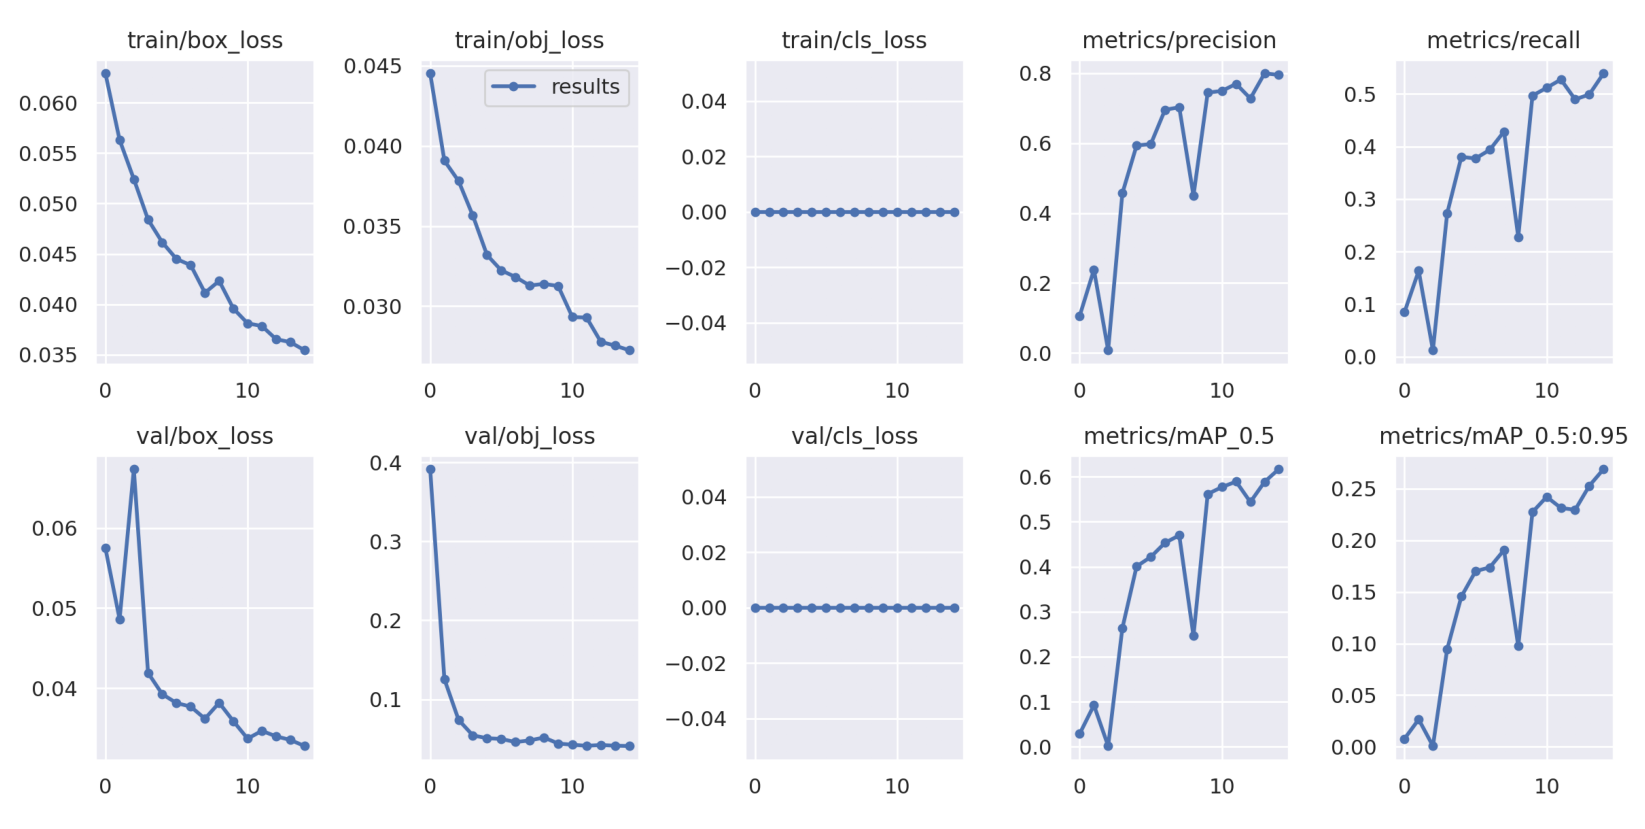

In [ ]:
# plot results per epoch 
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/results.png'));

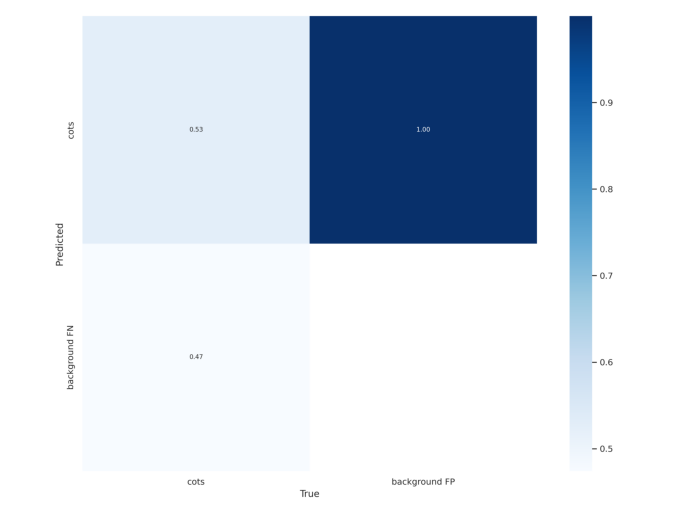

In [ ]:
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/confusion_matrix.png'));

Metric: F1
Metric: PR
Metric: P
Metric: R


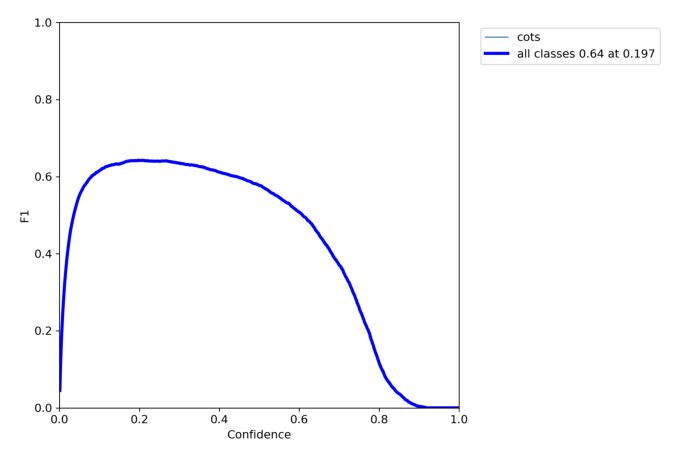

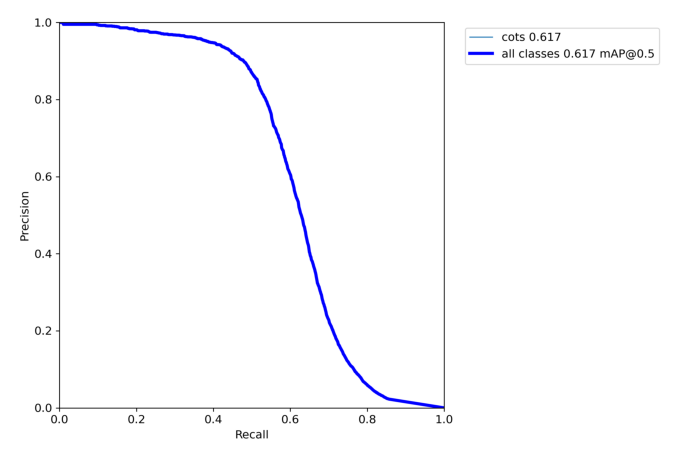

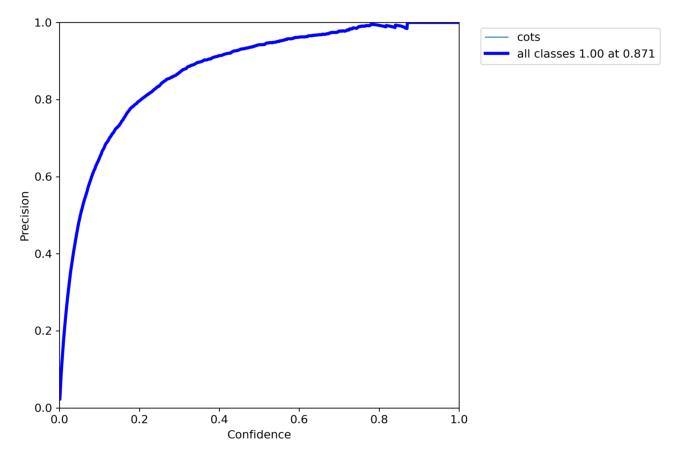

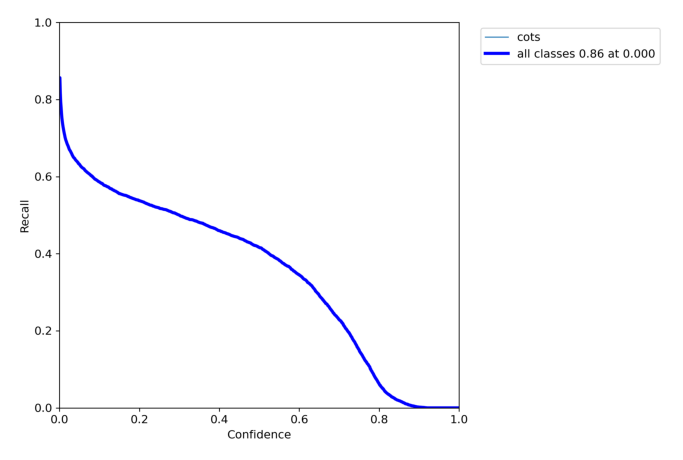

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2), 
                 axes_pad=0.1,  
                 )
for ax, metric in zip(grid, ['F1', 'PR', 'P', 'R']):
    ax.imshow(plt.imread(f'{OUTPUT_DIR}/{metric}_curve.png'))
    ax.axis('off')


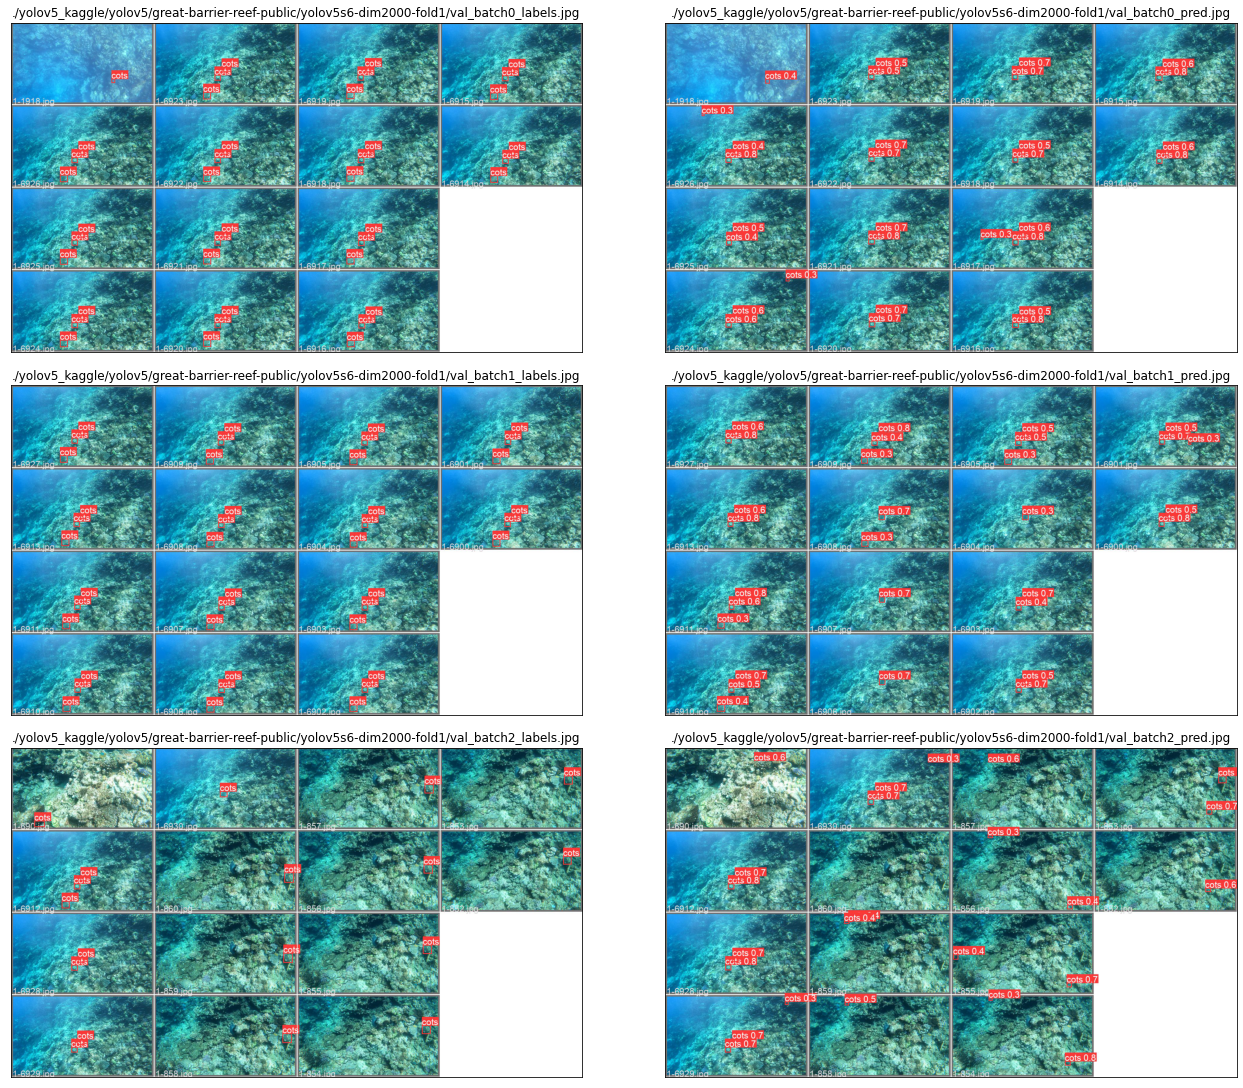

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (2*9,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'{OUTPUT_DIR}/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'{OUTPUT_DIR}/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'{OUTPUT_DIR}/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'{OUTPUT_DIR}/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

# Conclusion
The team was able to build a minimally viable product that detects COTS with reasonable performance on the test data. 

<img src = "https://drive.google.com/uc?export=view&id=1zdAkOz0xvffzsNWLz2KemCDRouXAPTws" />


###Lessons learned
* Machine learning, although filled with complex algorithms and equations is accessible even to novices through open source materials and models
* Open source software and code provide a solid base to begin developing own projects but can not be deployed without adjusting them to your projects needs
* Taking some time to understand the problem and data is important to project development
* Team work on data science projects adds value to the development process



#Resources
### Code Inspiration and Datasets

* [YOLOv5 Training](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train)
* [YOLOv5 Inference](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)
* [YOLOv5 with Tracking](https://www.kaggle.com/naturezhang/yolov5-detections-tracking-on-cot)
* COTS Pre-trained YOLOv5 model and datasets: [Sheep](https://www.kaggle.com/steamedsheep) and [Good Moon](https://www.kaggle.com/freshair1996)
* [Higher resolution and confidence](https://www.kaggle.com/macxiao/higher-resolution-and-confidence)

* [Yolov5 Baseline](https://www.kaggle.com/steamedsheep/yolov5-is-all-you-need)


#### Machine Learning 
* [Kaggle Intro To Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning)
* [Kaggle Intro To Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning)

#### Computer Vision
* [Kaggle Computer Vision ](https://www.kaggle.com/learn/computer-vision)

### YOLO
* [YOLOv5](https://docs.ultralytics.com/quick-start/)
* [AnalyticsVidhya](https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python)
* [YOLOv5 Tips for Best Results](https://docs.ultralytics.com/tutorials/training-tips-best-results/)

## Team
* [Sitwala](https://github.com/SitwalaM)
* [LaliAli](https://github.com/laliali20)
* [Antsa](https://github.com/AntsaHoneywinner)
* [Rhodasi](https://github.com/DhasiM)
* Tutor : [Martin Page](https://github.com/martinjpage)